In [2]:
import torch
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.feature_selection as fsl

In [3]:
X1 = pd.read_csv('X1.csv')
Y1 = pd.read_csv('Y1.csv', header = None, names = ['shares'])
df = X1
normalized_df=(df-df.min())/(df.max()-df.min())
X1 = normalized_df


In [4]:
#Finding the mutual information
import time
start_time = time.time()
mutualinfo = fsl.mutual_info_regression(X1, Y1.values.ravel())
print("--- %s seconds ---" % (time.time() - start_time))

--- 26.5191068649292 seconds ---


In [19]:
sorted_mutualinfo = np.sort(mutualinfo)[::-1]
features_to_take = 20
threshold = sorted_mutualinfo[features_to_take] 
print(threshold)
selected_mutinfo = np.argwhere(mutualinfo > threshold)
print(selected_mutinfo.T)
print(X1.columns[selected_mutinfo].shape)
print(X1.columns[selected_mutinfo])

0.011922771533410703
[[ 1  7  8 10 20 22 23 24 25 26 27 28 34 36 37 38 39 40 41 46]]
(20, 1)
[['n_tokens_content']
 ['num_imgs']
 ['num_videos']
 ['num_keywords']
 ['kw_min_max']
 ['kw_avg_max']
 ['kw_min_avg']
 ['kw_max_avg']
 ['kw_avg_avg']
 ['self_reference_min_shares']
 ['self_reference_max_shares']
 ['self_reference_avg_sharess']
 ['weekday_is_saturday']
 ['is_weekend']
 ['LDA_00']
 ['LDA_01']
 ['LDA_02']
 ['LDA_03']
 ['LDA_04']
 ['rate_positive_words']]


<ipython-input-19-1e1671389faf>:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(X1.columns[selected_mutinfo].shape)
<ipython-input-19-1e1671389faf>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  print(X1.columns[selected_mutinfo])


# MLP beginning


In [20]:
colnames = (X1.columns[selected_mutinfo]).reshape(-1)
#print(colnames)
X1_selected = X1


X_train, X_test, y_train, y_test = train_test_split(X1_selected, Y1, test_size=0.2, random_state=1)

<ipython-input-20-4ff6c1840cb4>:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  colnames = (X1.columns[selected_mutinfo]).reshape(-1)


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name()

'GeForce GTX 1050'

In [22]:
#defining utility class
#by defining this, you only have to write "for loop" to load minibatch data
class DataLoader(object):
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x,batch_y)

#defining MLP model
#generally out_dim is more than 1, but this model only allows 1.
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.linear1 = nn.Linear(self.in_dim, self.hidden_dim)
        self.linear2 = nn.Linear(self.hidden_dim, self.out_dim)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        hidden = self.linear1(x)
        relu = self.relu(hidden)
        output = self.linear2(relu)
        return output

In [23]:
#Convert to np array
x_train = X_train.values
y_train = y_train.values
x_valid = X_test.values
y_valid = y_test.values

In [24]:
#instantiate model
mlp = MLP(x_train.shape[1], 64, 1).to(device)
optimizer = optim.Adam(mlp.parameters())
train_dataloader = DataLoader(x_train, y_train, batch_size=64)
valid_dataloader = DataLoader(x_valid, y_valid, batch_size=64)

In [25]:
#this model learns to minimize MAE
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [26]:
#training phase
epochs = 100
#to plot loss curve after training
valid_losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_dataloader.data_size // train_dataloader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(train_dataloader):
        
        y_pred = mlp(batch_x)

        loss = mae_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = valid_dataloader.data_size // valid_dataloader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(valid_dataloader):
    
        y_pred = mlp(batch_x)
        loss = mae_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.model')  
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:194/248 Loss:2680.6394 Time:0m0.23s

Epoch:1 Batch:247/248 Loss:3957.4250 Time:0m0.29ss
Valid Loss:3397.4319
Epoch:2 Batch:247/248 Loss:2930.8364 Time:0m0.28ss
Valid Loss:3164.5577
Epoch:3 Batch:247/248 Loss:1831.8425 Time:0m0.29s
Valid Loss:2808.9880
Epoch:4 Batch:247/248 Loss:1661.0052 Time:0m0.28ss
Valid Loss:2587.2792
Epoch:5 Batch:247/248 Loss:1974.6406 Time:0m0.28s
Valid Loss:2526.3523
Epoch:6 Batch:247/248 Loss:1764.7166 Time:0m0.28ss
Valid Loss:2512.1218
Epoch:7 Batch:247/248 Loss:1506.4657 Time:0m0.30ss
Valid Loss:2509.8240
Epoch:8 Batch:247/248 Loss:1900.6609 Time:0m0.30s
Valid Loss:2504.7994
Epoch:9 Batch:247/248 Loss:3312.7700 Time:0m0.30ss
Valid Loss:2504.2069
Epoch:10 Batch:247/248 Loss:1887.2942 Time:0m0.30s
Valid Loss:2501.7878
Epoch:11 Batch:247/248 Loss:4534.7729 Time:0m0.27s
Valid Loss:2497.7053
Epoch:12 Batch:247/248 Loss:2613.0032 Time:0m0.28ss
Valid Loss:2496.8532
Epoch:13 Batch:247/248 Loss:2578.5483 Time:0m0.29s
Valid Loss:2492.1532
Epoch:14 Batch:247/248 Loss:2621.7754 Time:0m0.29ss
Valid Loss:249

minimum validation loss is 2453.5182


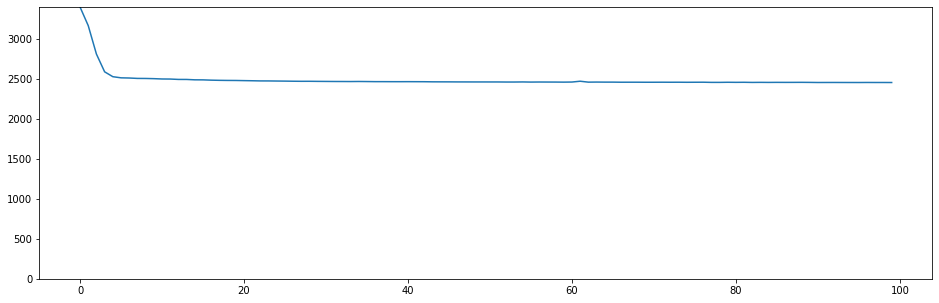

In [27]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.ylim(0,max(valid_losses)+0.02)
plt.plot(valid_losses)
print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

In [32]:
y_test = mlp(torch.tensor(X_test))

ValueError: could not determine the shape of object type 'DataFrame'